# Лабораторная работа № 7.1

### Задача:

Решить краевую задачу для дифференциального уравнения эллиптического типа.
Аппроксимацию уравнения произвести с использованием центрально-разностной
схемы. Для решения дискретного аналога применить следующие методы: метод
простых итераций (метод Либмана), метод Зейделя, метод простых итераций с
верхней релаксацией. Вычислить погрешность численного решения путем сравнения
результатов с приведенным в задании аналитическим решением
$U(x, y)$. Исследовать
зависимость погрешности от сеточных параметров
$hx$, $hy$.



In [532]:
import math, numpy as np, pandas as pd
import warnings
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import scipy.linalg
from matplotlib import cm
warnings.filterwarnings("ignore", category=DeprecationWarning) 

np.set_printoptions(precision=3)

def print_matrix(matrix):
    for row in matrix:
        for el in row:
            print("{:4.3f}".format(el), end=' ')
        print()

### Общий вид

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 
a\frac{\partial u}{\partial x} + b\frac{\partial u}{\partial y} + cu + f(x, t) $$

$$ \alpha_{1} u_x(0, y) + \beta_{1} u(0, y) = \phi_1(y) $$
$$ \alpha_{2} u_x(l_x, y) + \beta_{2} u(l_x, y) = \phi_2(y) $$
$$ \alpha_{3} u_y(x, 0) + \beta_{3} u(x, 0) = \phi_3(y) $$
$$ \alpha_{4} u_y(x, l_y) + \beta_{4} u(x, l_y) = \phi_4(y) $$

### Условие

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -u $$

$$ u(0, y) = 0 $$
$$ u(\frac{\pi}{2}, y) = y $$
$$ u_y(x, 0) = sin(x) $$
$$ u_y(x,1) - u(x, 1) = 0 $$

### Аналитическое решение


$$ U(x, y) = ysin(x) $$

### Численные методы

In [533]:
a, b, c = -2.0, -2.0, -4.0

lx, ly = np.pi / 2.0, np.pi / 2.0

f = lambda x, t: 0.0

alpha1, beta1, phi1 = 0.0, 20.0, lambda y: 20.0 * np.exp(-y)*np.cos(y)
alpha2, beta2, phi2 = 0.0, 1.0, lambda y: 0.0
alpha3, beta3, phi3 = 0.0, 1.0, lambda x: np.exp(-x)*np.cos(x)
alpha4, beta4, phi4 = 0.0, 1.0, lambda x: 0.0

nx, ny = 2, 2

decision = lambda x, y: np.exp(-x-y)*np.cos(x)*np.cos(y)

In [534]:
class EDES():
    
    def __init__(self, a, b, c, lx, ly, f, \
                 alpha1, beta1, phi1, \
                 alpha2, beta2, phi2, \
                 alpha3, beta3, phi3, \
                 alpha4, beta4, phi4, \
                 nx, ny):
        self.a, self.b, self.c = a, b, c

        self.lx, self.ly = lx, ly

        self.f = f

        self.alpha1, self.beta1, self.phi1 = alpha1, beta1, phi1
        self.alpha2, self.beta2, self.phi2 = alpha2, beta2, phi2
        self.alpha3, self.beta3, self.phi3 = alpha3, beta3, phi3
        self.alpha4, self.beta4, self.phi4 = alpha4, beta4, phi4

        self.nx, self.ny = nx, ny
    
        self.hx = lx / nx
        self.hy = ly / ny
        
        self.result = np.ndarray(shape=((nx+1), (ny+1)), dtype = np.float32)
    
    def k_ij(self, i, j):
        if (j == 0): return i - 1
        if (j == self.ny): return self.ny * (self.nx + 1) + i - 3
        
        return j * (self.nx + 1) + i - 2
    
    def x_i(self, i):
        return self.hx * i
    
    def y_j(self, j):
        return self.hy * j
    
    def ji_k(self, k):
        if k < self.nx - 1: return 0, k + 1
        if k >= self.ny * (self.nx + 1) - 2: return self.ny, k - self.ny * (self.nx + 1) + 3
        
        return (k + 2) // (self.nx + 1), (k + 2) % (self.nx + 1)
    
    def solve(self):
        self.A = np.zeros(shape=((self.nx+1) * (self.ny+1) - 4, (self.nx+1) * (self.ny+1) - 4), dtype = np.float32)
        self.d = np.zeros(shape=((self.nx+1) * (self.ny+1)) - 4, dtype = np.float32)
        
        gamma = ((-2.0/(self.hx**2)) + (-2.0/(self.hy**2)) - self.c)
        alpha_plus = (self.a / 2.0 / self.hx - 1.0 / (self.hx**2))
        alpha_minus = (-self.a / 2.0 / self.hx - 1.0 / (self.hx**2))
        beta_plus = (self.b/2.0/self.hy - 1.0 / (self.hy**2))
        beta_minus = (-self.b/2.0/self.hy - 1.0 / (self.hy**2))
        
        
        for i in range(1, self.nx): #3
            self.A[self.k_ij(i, 0)][self.k_ij(i, 0)] = self.beta3 - self.alpha3 / self.hy
            self.A[self.k_ij(i, 0)][self.k_ij(i, 1)] = self.alpha3 / self.hy
            self.d[self.k_ij(i, 0)] = self.phi3(self.x_i(i))
            
        for i in range(1, self.nx): #4
            self.A[self.k_ij(i, self.ny)][self.k_ij(i, self.ny)] = self.beta4 + self.alpha4 / self.hy
            self.A[self.k_ij(i, self.ny)][self.k_ij(i, self.ny - 1)] = -self.alpha4 / self.hy
            self.d[self.k_ij(i, self.ny)] = self.phi4(self.x_i(i))
            
        for j in range(1, self.ny): #1
            self.A[self.k_ij(0, j)][self.k_ij(0, j)] = self.beta1 - self.alpha1 / self.hx
            self.A[self.k_ij(0, j)][self.k_ij(1, j)] = self.alpha1 / self.hx
            self.d[self.k_ij(0, j)] = self.phi1(self.y_j(j))
            
        for j in range(1, self.ny): #2
            self.A[self.k_ij(self.nx, j)][self.k_ij(self.nx, j)] = self.beta2 + self.alpha2 / self.hx
            self.A[self.k_ij(self.nx, j)][self.k_ij(self.nx-1, j)] = -self.alpha2 / self.hx
            self.d[self.k_ij(self.nx, j)] = self.phi2(self.y_j(j))
            
        for i in range(1, self.nx):
            for j in range(1, self.ny):
                self.A[self.k_ij(i, j)][self.k_ij(i, j)] = -gamma
                self.A[self.k_ij(i, j)][self.k_ij(i+1, j)] = alpha_plus
                self.A[self.k_ij(i, j)][self.k_ij(i-1, j)] = alpha_minus
                self.A[self.k_ij(i, j)][self.k_ij(i, j+1)] = beta_plus
                self.A[self.k_ij(i, j)][self.k_ij(i, j-1)] = beta_minus
                self.d[self.k_ij(i, j)] = -self.f(self.x_i(i), self.y_j(j))
        
        
        self.result = scipy.linalg.solve(self.A, self.d)
        print_matrix(self.A)
        print(scipy.linalg.eigvalsh(self.A))
        return self
    
    def draw(self, decision = None):
        
        edes_result = np.zeros(shape=((self.ny+1), (self.nx+1)), dtype = np.float32)
        
        for k in range(0, len(self.result)):
            edes_result[*self.ji_k(k)] = self.result[k]

        decision_result = np.zeros(shape=((self.ny+1), (self.nx+1)), dtype = np.float32)

        for i in range(0, nx + 1):
            for j in range(0, ny + 1):
                decision_result[j, i] = decision(self.x_i(i), self.y_j(j))

        decision_result[0, 0] = 0.0
        decision_result[0, -1] = 0.0
        decision_result[-1, 0] = 0.0
        decision_result[-1, -1] = 0.0

        plt.subplot(121)
        plt.imshow(edes_result)
        plt.subplot(122)
        plt.imshow(decision_result)
        
        plt.subplots_adjust(bottom=0.1, right=1.8, top=0.9)
        cax = plt.axes([1.85, 0.11, 0.075, 0.78])
        plt.colorbar(cax = cax)
        plt.show()

1.000 0.000 0.000 0.000 0.000 
0.000 20.000 0.000 0.000 0.000 
-0.348 -0.348 2.485 -2.894 -2.894 
0.000 0.000 -0.000 1.000 0.000 
0.000 0.000 -0.000 0.000 1.000 
[ 0.922  1.     1.     2.555 20.007]


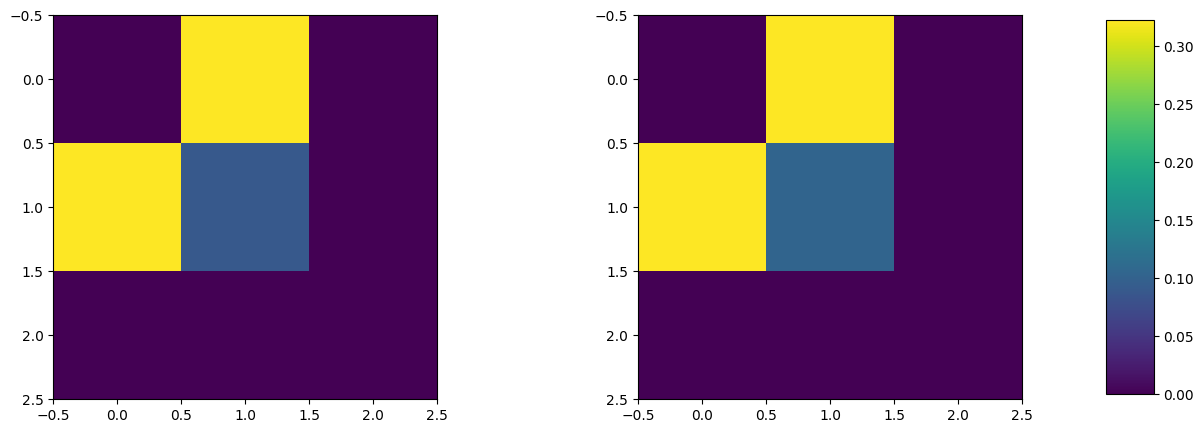

In [535]:
edes = EDES(a, b, c, lx, ly, f, alpha1, beta1, phi1, alpha2, beta2, phi2, alpha3, beta3, phi3, alpha4, beta4, phi4, nx, ny)
edes = edes.solve()
edes.draw(decision)